<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/parameter_estimation/parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=8ebc5ea0e163174ad5629ae910ab555a72108d8c1eb0ff3824b1bd2ed997870c
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15096 sha256=2df67f6c08bb8bd81a4ce0f3656178f0d4e31ab12f1b502401776ef241ecbf5e
  Stored in directory: /root/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout


In [3]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd  
import sys
from scipy.integrate import odeint
from time import time as clock
import random

In [4]:
# In order to access the package you need to have its path. The path required is the path WHERE that package is soterd, not it path
# sys.path.insert(1, 'd:\\DYNAMICAL SIMULATION\\maestria\\maestria')

In [5]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 351, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 351 (delta 70), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (351/351), 9.98 MiB | 18.97 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [6]:
cd maestria

/content/maestria


In [7]:
import utilis.functions as fn
from utilis.models import monod_model, inhibition_model

In [8]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 
ki = 0.3 # L/g

# I need to move this functions later

In [9]:
def plot_simulated_data(data):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.t, data.x, label = 'biomass')
    plt.scatter(data.t, data.s, label = 'substrate')
    plt.scatter(data.t, data.p, label = 'product')
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel('Concentration (g/L)', size = 20)
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()

In [10]:
def fitness_function_monod(parms):
    mu_max, yxs, ks, ypx = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_monod, out)

In [11]:
def fitness_function_inhibition(parms):
    mu_max, yxs, ks, ypx, ki = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(inhibition_model, x0, time, args =(0, mu_max, yxs, ks, ypx, ki, )).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_inhibition, out)

In [84]:
def calculate_stats(params):
    mean_values = np.mean(params, axis=0)
    std_values =  np.std(params, axis=0)
    stats = []
    for i in range(len(mean_values)):
        mean_value = mean_values[i]
        std_value = std_values[i]
        lower = mean_value - 1.96*std_value/np.sqrt(params.shape[0])
        upper = mean_value + 1.96*std_value/np.sqrt(params.shape[0])
        stats.append((mean_value, std_value, lower, upper))

    return stats

In [93]:
def plot_stats(data, real_value, y_label):
        
    mean = np.mean(data)
    confidence_interval = 1.96 * np.std(data) / np.sqrt(len(data))

    # Dibuja la gráfica
    plt.errorbar(1, mean, yerr=confidence_interval, fmt="o", color="red", label="Average value", markersize = 10)
    plt.scatter(np.full_like(data, 2), data, label = 'Estimation', s = 100)
    plt.scatter(3, real_value, c="blue", label="Actual value", s = 100)
    plt.xlim(0, 4)
    plt.xticks([1, 2, 3], ["Average value","Estimation", "Actual value"], size = 15)
    plt.ylabel(y_label, size = 20)
    plt.legend(fontsize=10)
    plt.grid()

# Load data

In [14]:
# Load data 
data_monod = pd.read_csv("data/data_monod.csv")
data_monod.head()

,t,x,s,p
0,0,0.242723,39.673568,0.320286
1,1,0.178948,39.776111,0.085047
2,2,0.325052,40.449577,0.366801
3,3,0.329567,40.093182,1.454305
4,4,0.425727,39.620962,1.313975


In [15]:
# Load data 
data_inhibition = pd.read_csv("data/data_inhibition.csv")
data_inhibition.head()

,t,x,s,p
0,0,0.174614,40.745821,1.081127
1,1,-0.060982,38.007323,-1.422682
2,2,0.087718,40.599858,-1.457520
3,3,0.242266,39.281919,0.688872
4,4,0.256444,40.626491,-0.866604


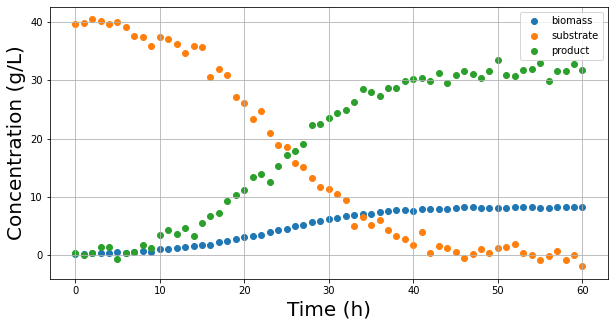

In [16]:
plot_simulated_data(data_monod)

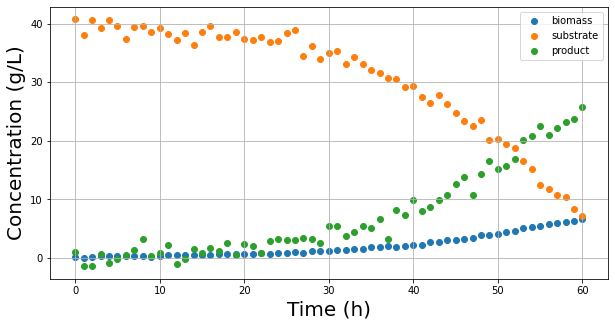

In [17]:
plot_simulated_data(data_inhibition)

# Valor de la funci{on fitness con valores corrector de los parámetros

In [18]:
fitness_function_monod([mu_max, yxs, ks, ypx])

1.8223412247601742

In [19]:
fitness_function_inhibition([mu_max, yxs, ks, ypx, ki])

2.221335566886478

# GA Configuration

In [20]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 50,\
                   'population_size':50,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.8,\
                   'parents_portion': 0.5,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
runs = 5

# Monod

In [21]:
# Establecer los rangos de busqueda para las variables de decision
varbound_monod=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10] # ypx
])

In [22]:
model_monod=ga(function=fitness_function_monod,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound_monod,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.10154076e+00 1.36353283e-01 2.78437594e+02 5.81180559e+00]

 Objective function:
 6.409090254068787


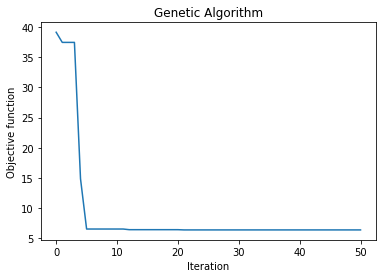

 The best solution found:
 [1.21437672e+00 2.48384151e-01 2.70279182e+02 3.17560455e+00]

 Objective function:
 3.5563627590916953


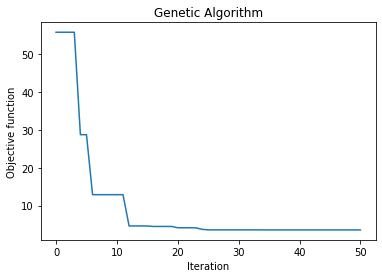

 The best solution found:
 [1.33802790e+00 2.59671455e-01 2.95018164e+02 2.96453327e+00]

 Objective function:
 4.9795826966148145


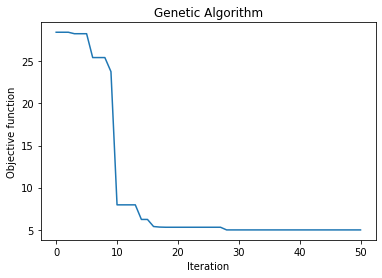

 The best solution found:
 [1.18896299e+00 2.14263058e-01 2.69729234e+02 3.59960749e+00]

 Objective function:
 2.2966693570238452


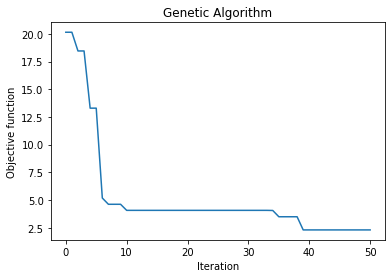

 The best solution found:
 [1.11070718e+00 1.78619824e-01 2.63063709e+02 4.16953623e+00]

 Objective function:
 4.14579768485789


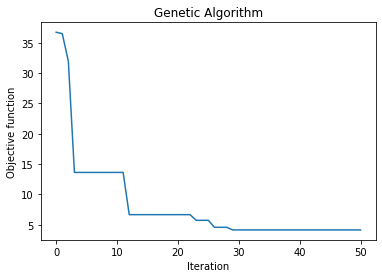

In [23]:

best_function_monod = []
best_values_monod = np.zeros((runs, varbound_monod.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(runs):
    model_monod.run()
    best_function_monod.append(model_monod.best_function)
    best_values_monod[i,:] = model_monod.best_variable
end_time = clock()

In [24]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 22.474s


In [25]:
print("Minimun fitness value:")
for best_function in best_function_monod:
    print(best_function)

Minimun fitness value:
6.409090254068787
3.5563627590916953
4.9795826966148145
2.2966693570238452
4.14579768485789


In [26]:
print("Average minimum function value:", np.mean(best_function_monod))

Average minimum function value: 4.277500550331406


In [27]:
print('Best solution found:')
for best_variables in best_values_monod: 
    print(best_variables)

Best solution found:
[1.10154076e+00 1.36353283e-01 2.78437594e+02 5.81180559e+00]
[1.21437672e+00 2.48384151e-01 2.70279182e+02 3.17560455e+00]
[1.33802790e+00 2.59671455e-01 2.95018164e+02 2.96453327e+00]
[1.18896299e+00 2.14263058e-01 2.69729234e+02 3.59960749e+00]
[1.11070718e+00 1.78619824e-01 2.63063709e+02 4.16953623e+00]


In [86]:
stats_monod = calculate_stats(best_values_monod)

In [87]:
for stats in stats_monod:
    print(stats)

(1.1907231112091863, 0.0855772555262691, 1.1157113394208202, 1.2657348829975523)
(0.2074583541058414, 0.045464326203978514, 0.1676071151200596, 0.2473095930916232)
(275.3055764811903, 10.996537486244884, 265.66668638933396, 284.94446657304667)
(3.9442174272338404, 1.0205838436163284, 3.0496362456167034, 4.838798608850977)


mu_max = 1.2  g/L

yxs = 0.2 

ks = 280  g/L

ypx = 4 

# Inhibition model

In [30]:
# Establecer los rangos de busqueda para las variables de decision
varbound_inhibition=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10], # ypx
    [0.05,0.5] # ki
])

In [31]:
model_inhibition=ga(function=fitness_function_inhibition,
         dimension=5,
         variable_type='real',
         variable_boundaries=varbound_inhibition,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.23060537e+00 2.30001496e-01 2.60895791e+02 3.25387841e+00
 3.02341996e-01]

 Objective function:
 2.652888103386562


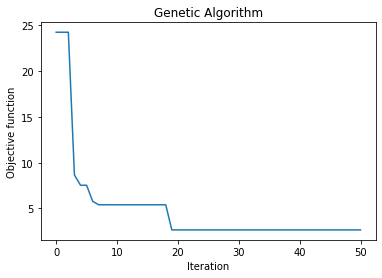

 The best solution found:
 [1.23631542e+00 2.02380487e-01 2.96266059e+02 4.12692384e+00
 3.07282237e-01]

 Objective function:
 2.5301980313508152


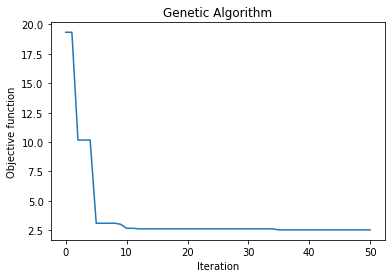

 The best solution found:
 [1.40379571e+00 1.81862214e-01 2.82818062e+02 4.40131156e+00
 4.18934765e-01]

 Objective function:
 2.3874287764118622


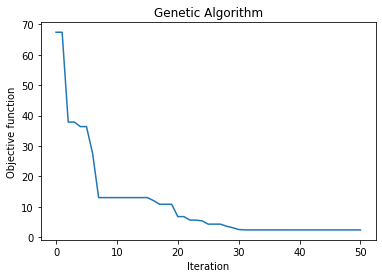

 The best solution found:
 [1.19748568e+00 1.29084029e-01 2.54223694e+02 5.84716561e+00
 4.02457124e-01]

 Objective function:
 3.292713410813853


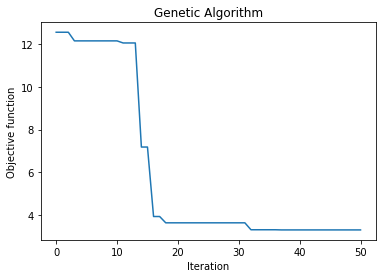

 The best solution found:
 [  1.0844567    0.26881817 215.25045037   2.89433494   0.25360225]

 Objective function:
 3.6957103011169483


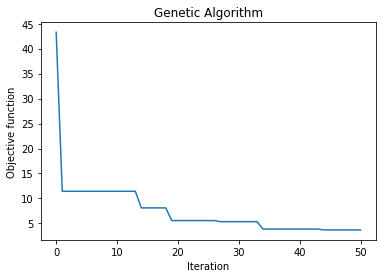

In [32]:
best_function_inhibition = []
best_values_inhibition = np.zeros((runs, varbound_inhibition.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(runs):
    model_inhibition.run()
    best_function_inhibition.append(model_inhibition.best_function)
    best_values_inhibition[i,:] = model_inhibition.best_variable
end_time = clock()

In [33]:
total_time_inhibition = end_time - start_time
print(f"Total time: {total_time_inhibition:.3f}s")

Total time: 15.760s


In [34]:
print("Minimun fitness value:")
for best_function in best_function_inhibition:
    print(best_function)

Minimun fitness value:
2.652888103386562
2.5301980313508152
2.3874287764118622
3.292713410813853
3.6957103011169483


In [35]:
print("Average minimum function value:", np.mean(best_function_inhibition))

Average minimum function value: 2.911787724616008


In [36]:
print('Best solution found:')
for best_variables in best_values_inhibition: 
    print(best_variables)

Best solution found:
[1.23060537e+00 2.30001496e-01 2.60895791e+02 3.25387841e+00
 3.02341996e-01]
[1.23631542e+00 2.02380487e-01 2.96266059e+02 4.12692384e+00
 3.07282237e-01]
[1.40379571e+00 1.81862214e-01 2.82818062e+02 4.40131156e+00
 4.18934765e-01]
[1.19748568e+00 1.29084029e-01 2.54223694e+02 5.84716561e+00
 4.02457124e-01]
[  1.0844567    0.26881817 215.25045037   2.89433494   0.25360225]


In [88]:
stats_inhibition = calculate_stats(best_values_inhibition)

In [89]:
for stats in stats_inhibition:
    print(stats)

(1.2305317759885943, 0.10245371633241622, 1.1407271340760232, 1.3203364179011654)
(0.20242927984348708, 0.046840676041253825, 0.16137161703329367, 0.24348694265368048)
(261.89081122572435, 27.76582611615191, 237.55299156403973, 286.22863088740894)
(4.10472287021542, 1.030877264328701, 3.2011191075322065, 5.008326632898634)
(0.3369236744156067, 0.06330468990756953, 0.28143466716388155, 0.3924126816673319)


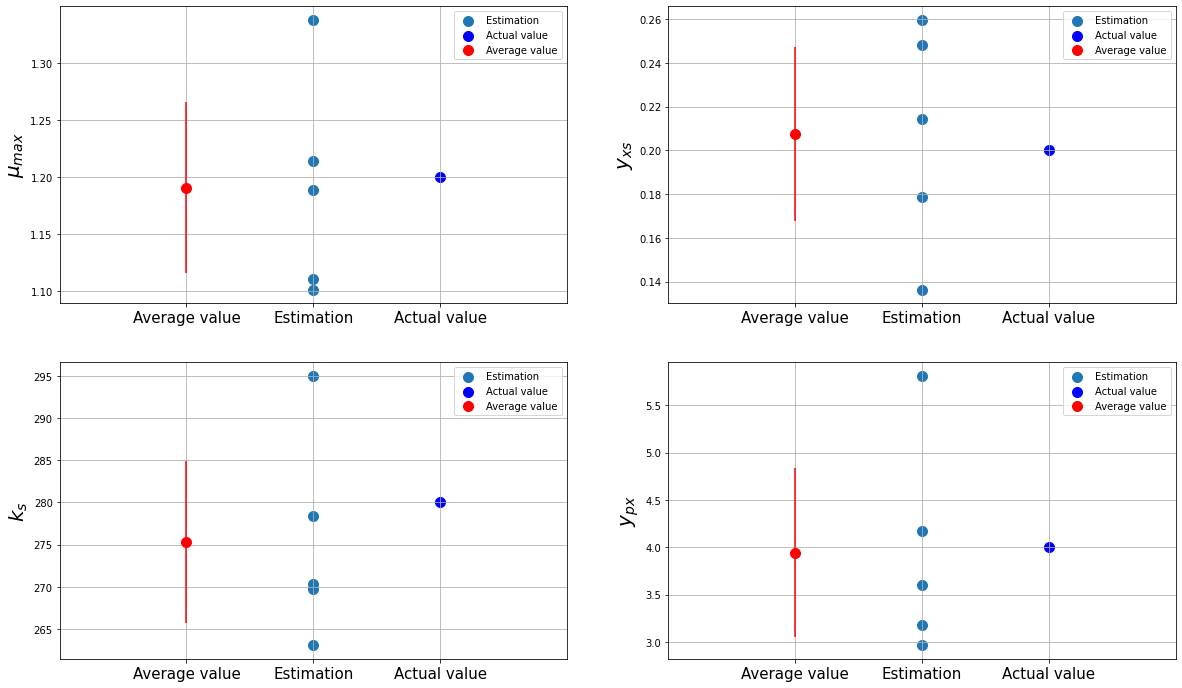

In [94]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_monod[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_monod[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_monod[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_monod[:, 3], ypx, "$y_{px}$")
plt.show()

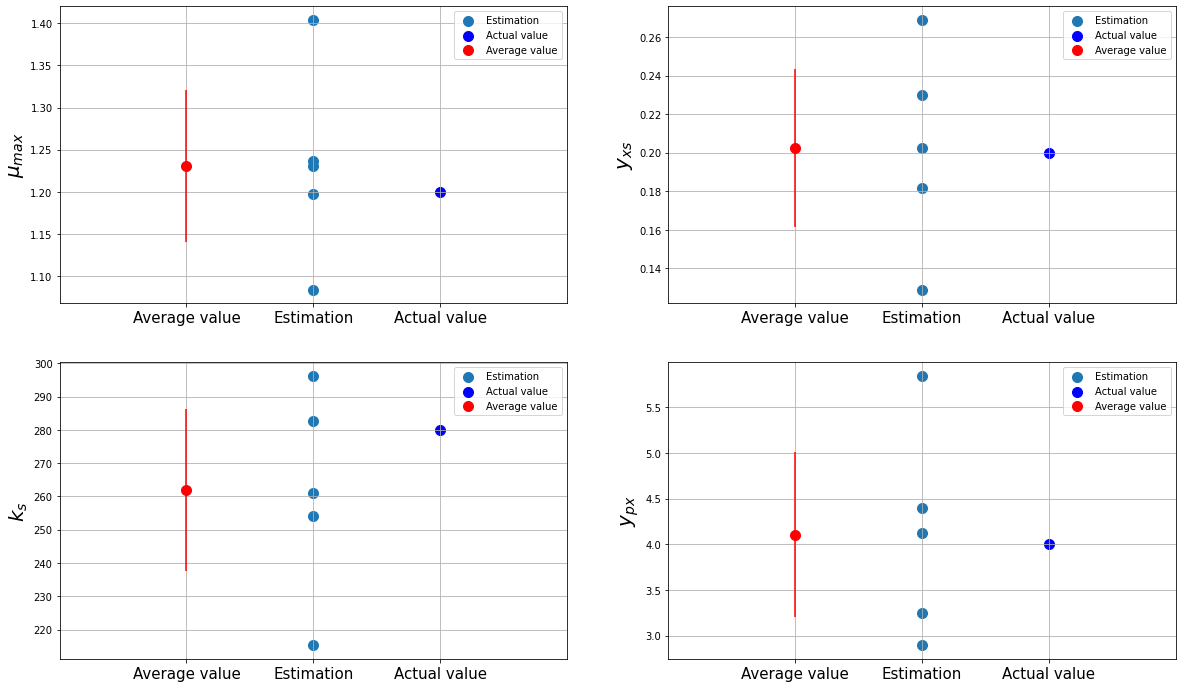

In [95]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_inhibition[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_inhibition[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_inhibition[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_inhibition[:, 3], ypx, "$y_{px}$")
plt.show()

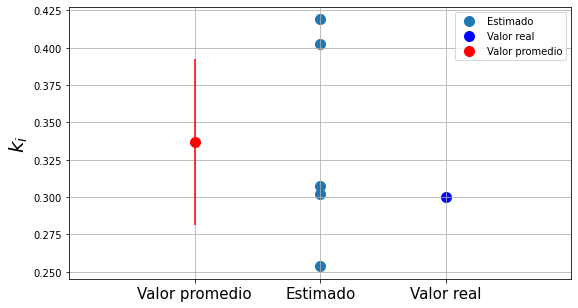

In [92]:
plt.figure(figsize=(9,5))
plot_stats(best_values_inhibition[:, 4], ki, "$k_i$")
plt.show()